In [1]:
from gp_diffscales_withavgloss_fixkernel_trueavg_logit_init import*
%load_ext autoreload
%autoreload 2

In [2]:
# 1. Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5  # Example dimensions
sim_data = generate_synthetic_data(N, D, T, K, P, return_true_params=True)

# 2. Compute smoothed prevalence
prevalence_t = compute_smoothed_prevalence(sim_data['Y'], window_size=5)


In [3]:

# 3. Initialize model
model = AladynSurvivalFixedKernelsAvgLoss_logitinit(
    N=N, D=D, T=T, K=K, P=P,
    G=sim_data['G'],
    Y=sim_data['Y'],
    prevalence_t=prevalence_t
   
)

# 4. Fit model
history = model.fit(
    event_times=sim_data['event_times'],
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)


Epoch 0, Loss: 167.8281
Epoch 100, Loss: 43.3237
Epoch 200, Loss: 34.4265
Epoch 300, Loss: 32.7670
Epoch 400, Loss: 31.8042
Epoch 500, Loss: 31.0603
Epoch 600, Loss: 30.4357
Epoch 700, Loss: 29.8792
Epoch 800, Loss: 29.3652
Epoch 900, Loss: 28.8829


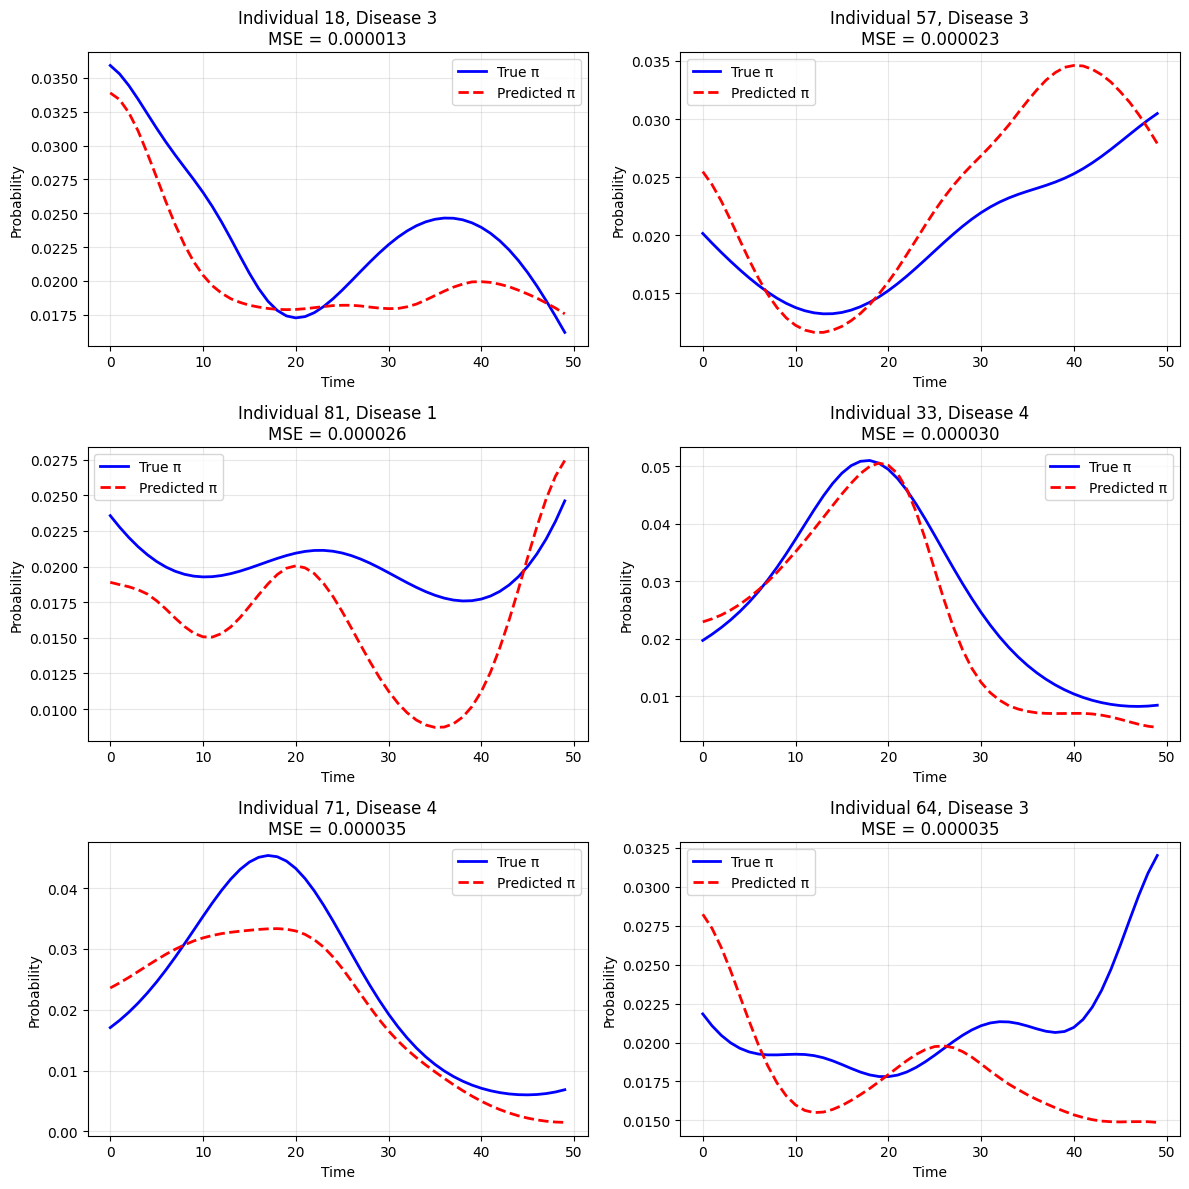

In [5]:
plot_best_matches(sim_data['pi'], model.forward()[0], n_samples=6)

In [6]:
def analyze_lambda(model):
    """
    Analyze final lambda values from trained model
    """
    # Extract lambda values
    lambda_values = model.lambda_.detach().numpy()  # N x K x T
    
    # Plot distributions and temporal patterns
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Distribution of lambda values
    axes[0].hist(lambda_values.flatten(), bins=50)
    axes[0].set_title('Distribution of Lambda Values')
    axes[0].set_xlabel('Lambda Value')
    axes[0].set_ylabel('Count')
    
    # Temporal patterns for a few individuals
    n_show = 5
    random_inds = np.random.choice(lambda_values.shape[0], n_show)
    for i in random_inds:
        for k in range(lambda_values.shape[1]):
            axes[1].plot(lambda_values[i, k, :], 
                        alpha=0.5, label=f'Individual {i}, Topic {k}')
    
    axes[1].set_title('Lambda Temporal Patterns')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Lambda Value')
    if lambda_values.shape[1] <= 3:  # Only show legend if not too many topics
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nLambda Summary Statistics:")
    print(f"Mean: {np.mean(lambda_values):.3f}")
    print(f"Std: {np.std(lambda_values):.3f}")
    print(f"Min: {np.min(lambda_values):.3f}")
    print(f"Max: {np.max(lambda_values):.3f}")

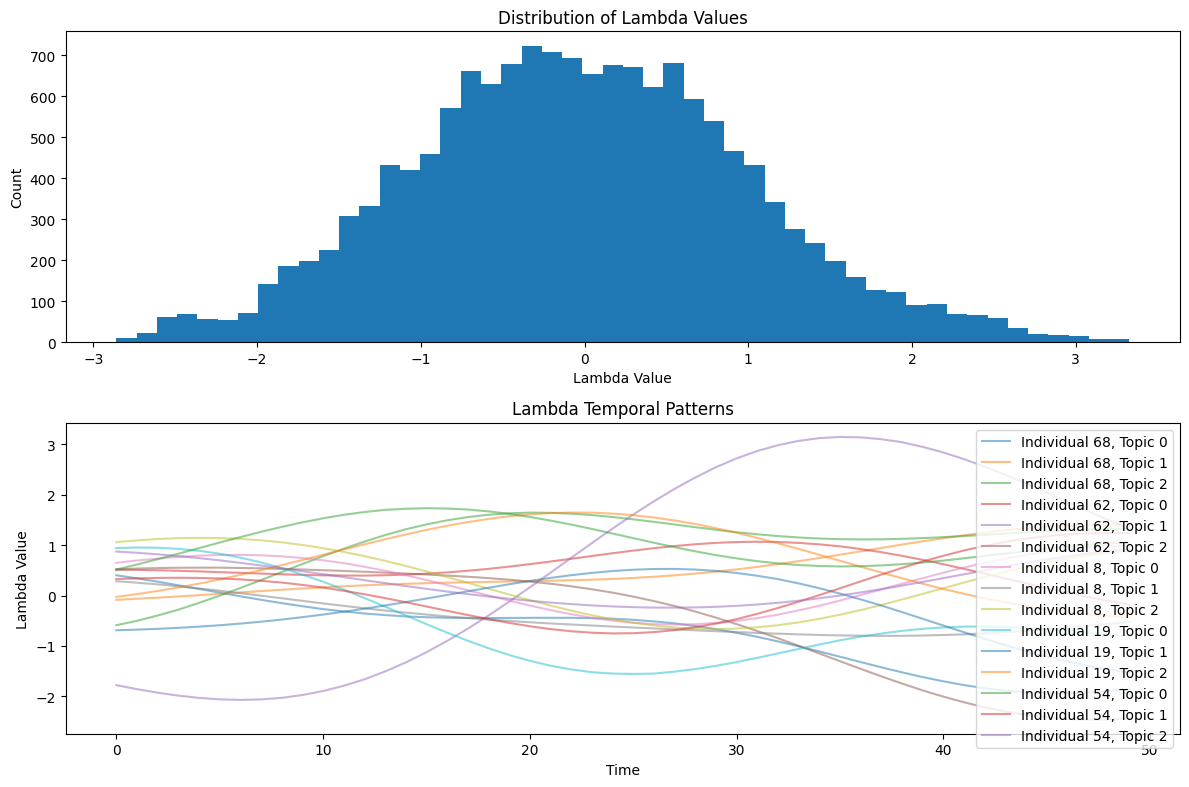


Lambda Summary Statistics:
Mean: -0.031
Std: 1.024
Min: -2.860
Max: 3.328


In [7]:
analyze_lambda(model=model)

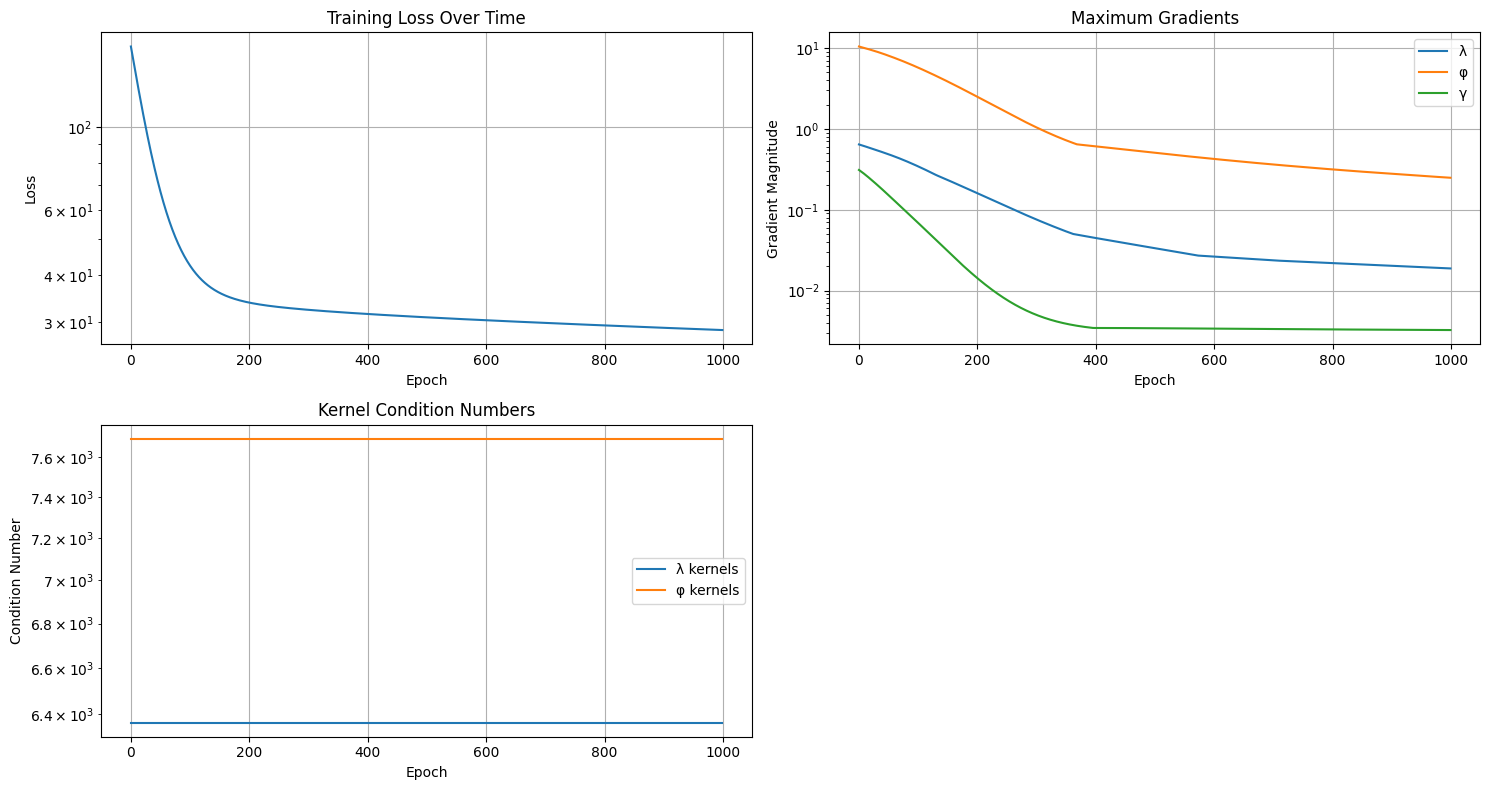

In [8]:

# 5. Plot diagnostics
plot_training_diagnostics(history)



In [4]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51
10


In [5]:
from gp_diffscales_withavgloss_fixkernel_trueavg_logit_init import *
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernelsAvgLoss_logitinit(
    N=N, D=D, T=T, K=K, P=P,
    G=G,
    Y=Y,
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

Epoch 0, Loss: 592.7430
Epoch 100, Loss: 164.5145
Epoch 200, Loss: 133.9431


In [55]:
from cluster_g import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [83]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y, prevalence_t)
disease_names_list = disease_names[0].tolist()
# Look at initial clusters
model.visualize_clusters(disease_names_list)

Starting initialization...


/opt/miniconda3/envs/pyro_env/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


Initializing other parameters...
Initialization complete!


/opt/miniconda3/envs/pyro_env/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(



Cluster Assignments:

Cluster 0:
  - Thrombocytopenia (prevalence: 0.0002)
  - Other anemias (prevalence: 0.0020)
  - Hypovolemia (prevalence: 0.0008)
  - Pleurisy; pleural effusion (prevalence: 0.0013)
  - Hypotension NOS (prevalence: 0.0008)
  - Pneumonia (prevalence: 0.0008)
  - Hyposmolality and/or hyponatremia (prevalence: 0.0007)
  - Pneumococcal pneumonia (prevalence: 0.0012)
  - Acute renal failure (prevalence: 0.0016)
  - Pulmonary heart disease (prevalence: 0.0006)
  - Major depressive disorder (prevalence: 0.0021)
  - Candidiasis (prevalence: 0.0004)
  - Constipation (prevalence: 0.0021)
  - Bacterial infection NOS (prevalence: 0.0009)
  - Urinary tract infection (prevalence: 0.0019)
  - Decubitus ulcer (prevalence: 0.0004)
  - Other diseases of respiratory system, NEC (prevalence: 0.0011)
  - Chronic renal failure [CKD] (prevalence: 0.0007)
  - Orthostatic hypotension (prevalence: 0.0004)
  - Hypopotassemia (prevalence: 0.0005)
  - Gram negative septicemia (prevalence: 0.0

In [84]:
print("Model parameters:")
print("psi:", model.psi)
print("lambda:", model.lambda_.shape)
print("phi:", model.phi.shape)
print("logit_prev_t:", model.logit_prev_t.shape)

Model parameters:
psi: Parameter containing:
tensor([[-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000,  1.0000],
        [ 1.0000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        ...,
        [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       requires_grad=True)
lambda: torch.Size([9661, 10, 51])
phi: torch.Size([10, 348, 51])
logit_prev_t: torch.Size([348, 51])


In [86]:
history = model.fit(event_times=E_tensor, 
                   num_epochs=1000, 
                   learning_rate=1e-3)

Starting training...


/Users/sarahurbut/aladynoulli/pyScripts/cluster_g.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = mu_dt.unsqueeze(0) + self.psi.unsqueeze(-1)


Epoch 0, Loss: 84.2731


In [ ]:
from gp_diffscales_withavgloss_fixkernel_trueavg import *
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernelsAvgLoss(
    N=N, D=D, T=T, K=K, P=P,
    G=G,
    Y=Y,
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

In [22]:

import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))


In [ ]:

K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()




In [ ]:
def evaluate_event_prediction(model, Y, E):
    """
    Evaluate how well the model predicts events
    """
    # Get predictions and convert everything to numpy
    pi_pred, _, _ = model.forward()
    pi_np = pi_pred.detach().numpy()
    Y_np = Y.detach().numpy()
    E_np = E.detach().numpy().astype(int)  # Convert to integer indices
    
    # Get probabilities at event times
    event_probs = []
    non_event_probs = []
    
    N, D, _ = Y_np.shape
    
    for i in range(N):
        for d in range(D):
            event_time = int(E_np[i,d])  # Ensure integer index
            try:
                if Y_np[i,d,event_time] == 1:  # If there's an event
                    event_probs.append(pi_np[i,d,event_time])
                else:
                    non_event_probs.append(pi_np[i,d,event_time])
            except IndexError:
                print(f"Warning: Index error at i={i}, d={d}, t={event_time}")
                continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    if event_probs:  # Only plot if we have events
        plt.hist(event_probs, alpha=0.5, label='Event probabilities', 
                density=True, bins=30, color='blue')
    if non_event_probs:  # Only plot if we have non-events
        plt.hist(non_event_probs, alpha=0.5, label='Non-event probabilities', 
                density=True, bins=30, color='red')
    
    plt.title('Distribution of Predicted Probabilities at Event Times')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Print summary statistics
    if event_probs:
        print(f"Mean probability at events: {np.mean(event_probs):.3f}")
        print(f"Number of events: {len(event_probs)}")
    if non_event_probs:
        print(f"Mean probability at non-events: {np.mean(non_event_probs):.3f}")
        print(f"Number of non-events: {len(non_event_probs)}")

# Use the function
evaluate_event_prediction(model, Y_tensor, E_tensor)

In [ ]:
# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()
disease_names_list = disease_names[0].tolist()

prs_names_list = prs_names[0].tolist()
def plot_phi_heatmaps_with_labels(phi_pred, K, D, T, disease_names, n_top=20):
    """
    Plot heatmaps of phi values for each topic, showing top n diseases based on their importance to the topic.
    
    Parameters:
    phi_pred: predicted phi values (K x D x T)
    K: number of topics
    D: number of diseases
    T: number of timepoints
    disease_names: list of disease names
    n_top: number of top diseases to show per topic
    """
    phi_np = phi_pred.detach().numpy()
    
    fig, axes = plt.subplots(K, 1, figsize=(15, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        # Find top n diseases for this topic based on maximum absolute values
        #topic_max = np.max(np.abs(phi_np[k]), axis=1) 
        topic_max = np.mean(phi_np[k], axis=1)  # Max across time for each disease
        top_indices = np.argsort(topic_max)[-n_top:][::-1]  # Get indices of top n diseases
        
        # Get the data for just these top diseases
        top_data = phi_np[k, top_indices]
        
        # Plot the data
        im = axes[k].imshow(top_data, aspect='auto', cmap='RdBu_r')
        plt.colorbar(im, ax=axes[k])
        
        axes[k].set_title(f'Topic {k} - Top {n_top} Disease Patterns')
        axes[k].set_xlabel('Time')
        axes[k].set_ylabel('Disease')
        
        # Use disease names for top diseases only
        axes[k].set_yticks(range(n_top))
        disease_labels = [f"{disease_names[i]} (max={topic_max[i]:.3f})" 
                         for i in top_indices]
        axes[k].set_yticklabels(disease_labels)
        
        time_ticks = np.linspace(0, T-1, 5, dtype=int)
        axes[k].set_xticks(time_ticks)
        axes[k].set_xticklabels(time_ticks)
        
        # Add grid for better readability
        axes[k].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Return top indices for each topic
    top_indices_per_topic = [np.argsort(np.max(np.abs(phi_np[k]), axis=1))[-n_top:][::-1] 
                            for k in range(K)]
    return top_indices_per_topic

# Usage:
top_indices = plot_phi_heatmaps_with_labels(
    phi_pred, K, D, T, disease_names_list, n_top=20
)

In [ ]:
disease_names

In [ ]:
def analyze_disease_clusters(Y, disease_names, n_clusters=10, min_prevalence=0.01, output_pdf="disease_clusters.pdf"):
    """
    Analyze disease clusters based on co-occurrence patterns and save to PDF
    
    Parameters:
    Y: disease occurrence array (N x D x T)
    disease_names: list of disease names
    n_clusters: number of desired clusters
    min_prevalence: minimum disease prevalence to include
    output_pdf: path to save the PDF output
    """
    import numpy as np
    from sklearn.cluster import SpectralClustering
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage
    from matplotlib.backends.backend_pdf import PdfPages
    
    # Create PDF
    pdf = PdfPages(output_pdf)
    
    # Convert to binary occurrence matrix
    Y_any = (np.sum(Y, axis=2) > 0).astype(float)  # N x D
    
    # Calculate disease prevalence
    prevalence = Y_any.mean(axis=0)
    
    # Filter rare diseases
    common_diseases = prevalence >= min_prevalence
    Y_filtered = Y_any[:, common_diseases]
    names_filtered = [name for name, keep in zip(disease_names, common_diseases) if keep]
    
    # Compute co-occurrence matrix
    cooc = Y_filtered.T @ Y_filtered  # D x D
    
    # Normalize by prevalence to get phi coefficient
    prev_matrix = prevalence[common_diseases][:, None] @ prevalence[common_diseases][None, :]
    cooc_norm = (cooc / Y_filtered.shape[0] - prev_matrix) / np.sqrt(
        prev_matrix * (1 - prev_matrix) + 1e-8)
    
    # Set diagonal to 0
    np.fill_diagonal(cooc_norm, 0)
    
    # Perform clustering
    clustering = SpectralClustering(n_clusters=n_clusters, 
                                  affinity='precomputed',
                                  random_state=42)
    
    # Convert to similarity matrix
    similarity = np.exp(cooc_norm)
    clusters = clustering.fit_predict(similarity)
    
    # 1. Hierarchical clustering visualization
    plt.figure(figsize=(20, 15))
    linkage_matrix = linkage(cooc_norm, method='ward')
    dendrogram(linkage_matrix, labels=names_filtered, leaf_rotation=90)
    plt.title('Hierarchical Clustering of Diseases')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 2. Correlation heatmap with cluster boundaries
    plt.figure(figsize=(20, 15))
    # Sort by cluster
    cluster_order = np.argsort(clusters)
    cooc_sorted = cooc_norm[cluster_order][:, cluster_order]
    names_sorted = [names_filtered[i] for i in cluster_order]
    
    sns.heatmap(cooc_sorted, xticklabels=names_sorted, yticklabels=names_sorted)
    plt.title('Disease Co-occurrence Pattern (Sorted by Cluster)')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 3. Create a text page with cluster contents
    plt.figure(figsize=(20, 15))
    plt.axis('off')
    text_content = "Disease Clusters:\n\n"
    
    for k in range(n_clusters):
        cluster_diseases = [names_filtered[i] for i in range(len(clusters)) if clusters[i] == k]
        text_content += f"\nCluster {k+1}:\n"
        for disease in cluster_diseases:
            prev = prevalence[disease_names.index(disease)]
            text_content += f"  - {disease} (prevalence: {prev:.3f})\n"
    
    plt.text(0.1, 0.9, text_content, fontsize=12, verticalalignment='top')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # Close PDF
    pdf.close()
    
    print(f"Analysis saved to {output_pdf}")
    return clusters, common_diseases

# Use the function
clusters, common_diseases = analyze_disease_clusters(Y, disease_names_list, 
                                                   n_clusters=K, 
                                                   output_pdf="disease_clusters.pdf")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Y (N x D x T) and G (N x P) are your data
# and disease_names is your list of disease names

def test_initialization(Y, G, K=10, disease_names=None):
    """
    Test factor initialization and visualize results
    """
    N, D, T = Y.shape
    
    # Convert to torch tensors if needed
    Y = torch.tensor(Y, dtype=torch.float32)
    G = torch.tensor(G, dtype=torch.float32)
    
    # Compute average disease occurrence
    Y_avg = torch.mean(Y, dim=2)  # N x D
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = torch.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    
    # Center the logit-transformed data
    disease_means = torch.mean(Y_logit, dim=0)
    Y_centered = Y_logit - disease_means[None, :]
    
    # Perform SVD
    U, S, Vh = torch.linalg.svd(Y_centered, full_matrices=False)
    
    # Initialize lambda and phi
    lambda_init = U[:, :K] @ torch.diag(torch.sqrt(S[:K]))
    gamma_init = torch.linalg.lstsq(G, lambda_init).solution
    phi_base = Vh[:K, :].T * torch.sqrt(S[:K])  # D x K
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # 1. Plot singular values
    plt.subplot(2, 2, 1)
    plt.plot(S.numpy(), 'o-')
    plt.title('Singular Values')
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    
    # 2. Plot disease loadings heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(phi_base.numpy(), 
                xticklabels=[f'Factor {i+1}' for i in range(K)],
                yticklabels=disease_names if disease_names else None)
    plt.title('Disease Loadings (Phi)')
    
    # 3. Print top diseases for each factor
    plt.figure(figsize=(15, 10))
    n_top = 10  # number of top diseases to show
    
    for k in range(min(K, 10)):  # Show first 6 factors
        plt.subplot(3, 4, k+1)
        
        # Get top diseases for this factor
        factor_loadings = phi_base[:, k].numpy()
        top_idx = np.argsort(np.abs(factor_loadings))[-n_top:]
        
        # Plot bar chart
        plt.barh(range(n_top), factor_loadings[top_idx])
        plt.yticks(range(n_top), 
                  [disease_names[i] if disease_names else f"Disease {i}" 
                   for i in top_idx])
        plt.title(f'Factor {k+1} Top Diseases')
    
    plt.tight_layout()
    
    # Print some statistics
    print("\nInitialization Statistics:")
    print(f"Lambda scale: mean={lambda_init.mean():.3f}, std={lambda_init.std():.3f}")
    print(f"Gamma scale: mean={gamma_init.mean():.3f}, std={gamma_init.std():.3f}")
    print(f"Phi scale: mean={phi_base.mean():.3f}, std={phi_base.std():.3f}")
    
    return lambda_init, gamma_init, phi_base, S

# Run the test
lambda_init, gamma_init, phi_base, S = test_initialization(Y, G, K=10, disease_names=disease_names_list)

In [79]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [81]:

def varimax_rotation(loadings, max_iter=1000, tol=1e-6):
    """Apply varimax rotation to loadings matrix"""
    n_rows, n_cols = loadings.shape
    rotation = np.eye(n_cols)
    
    var_old = 0
    for _ in range(max_iter):
        basis = loadings @ rotation
        h = basis ** 2
        mu = h.mean(axis=0, keepdims=True)
        term1 = basis ** 3
        term2 = basis @ np.diag(mu.squeeze())
        u = term1 - term2 @ np.ones((n_cols, n_cols)) / n_cols
        
        gradient = loadings.T @ u
        U, S, Vh = np.linalg.svd(gradient)
        rotation = U @ Vh
        
        var_new = np.sum(h ** 2)
        if np.abs(var_new - var_old) < tol:
            break
        var_old = var_new
    
    return loadings @ rotation


In [ ]:
visualize_topics(Y)

In [82]:
def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_matrix = np.mean(Y, axis=2)  # N x D matrix
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()


In [84]:
def visualize_topics(Y, K=10, n_top_diseases=10, disease_names_list=None):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    logit_mean = np.log((Y_mean + epsilon) / (1 - Y_mean + epsilon))

    # Get individual deviations in logit space
    Y_matrix = np.mean(Y, axis=2)  # Time-averaged
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_deviations = Y_logit - logit_mean
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        if disease_names_list is not None:
            labels = [f"{disease_names_list[i]} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        else:
            labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
            
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()

In [ ]:
visualize_topics(Y,disease_names_list=disease_names_list)

In [13]:
def visualize_disease_clusters(Y_avg, K):
    # Compute similarity matrix
    Y_corr = torch.corrcoef(Y_avg.T)  # D x D correlation matrix
    similarity = (Y_corr + 1) / 2  # Scale to [0,1]
    
    # Compute clusters
    clusters = SpectralClustering(n_clusters=K-1).fit_predict(similarity.numpy())
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Similarity matrix
    plt.subplot(121)
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar()
    plt.title('Disease Similarity Matrix')
    plt.xlabel('Disease Index')
    plt.ylabel('Disease Index')
    
    # Plot 2: Cluster assignments
    plt.subplot(122)
    for k in range(K-1):
        plt.scatter(np.where(clusters == k)[0], 
                   np.zeros_like(np.where(clusters == k)[0]), 
                   label=f'Cluster {k}')
    plt.title('Disease Cluster Assignments')
    plt.xlabel('Disease Index')
    plt.yticks([])
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return clusters, similarity

In [24]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import torch
Y=torch.tensor(Y, dtype=torch.float32) 
Y_avg = torch.mean(Y, dim=2)

/opt/miniconda3/envs/pyro_env/lib/python3.9/site-packages/sklearn/cluster/_spectral.py:702: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


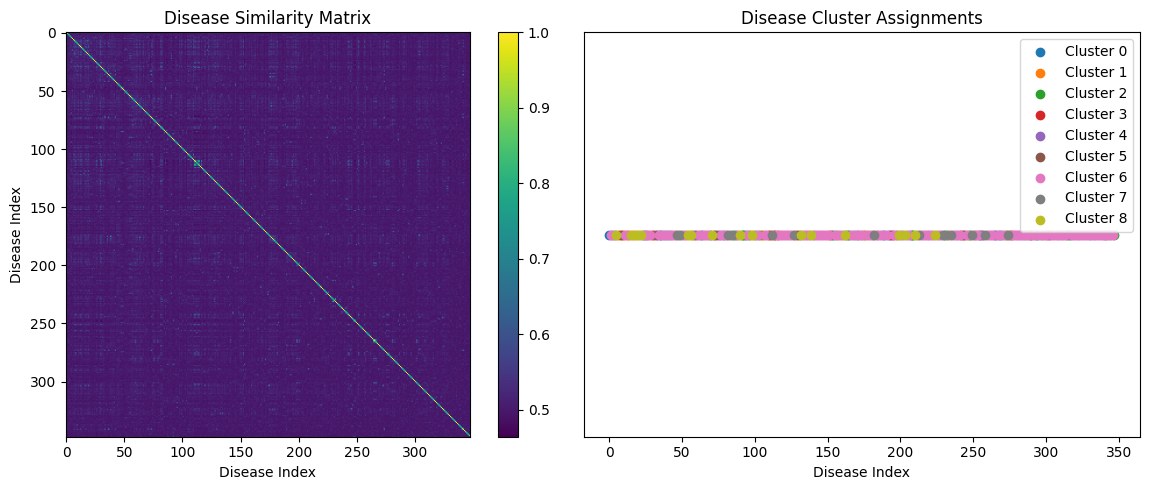

(array([0, 6, 4, 6, 0, 8, 1, 1, 3, 5, 1, 6, 1, 1, 6, 8, 1, 1, 8, 1, 8, 6,
        8, 0, 6, 0, 3, 6, 6, 1, 3, 1, 4, 5, 6, 0, 5, 6, 0, 6, 0, 6, 5, 6,
        6, 1, 6, 7, 7, 7, 6, 6, 6, 6, 8, 8, 8, 4, 1, 4, 1, 1, 6, 0, 4, 6,
        1, 6, 6, 0, 6, 8, 5, 5, 1, 4, 4, 6, 4, 4, 6, 1, 7, 6, 2, 7, 2, 2,
        6, 6, 8, 2, 2, 2, 0, 6, 2, 1, 8, 1, 2, 6, 6, 2, 1, 1, 1, 6, 6, 1,
        3, 3, 7, 3, 3, 6, 3, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 7, 1, 5, 1, 0,
        8, 6, 6, 6, 1, 6, 6, 8, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 3, 2,
        0, 6, 2, 1, 6, 6, 6, 6, 8, 2, 0, 2, 6, 6, 4, 6, 2, 4, 6, 6, 1, 0,
        1, 6, 1, 6, 6, 3, 7, 6, 6, 6, 6, 6, 4, 0, 6, 6, 0, 0, 3, 1, 6, 1,
        4, 8, 4, 6, 6, 8, 6, 6, 6, 0, 0, 2, 8, 6, 6, 7, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 8, 6, 6, 6, 6, 7, 2, 7, 2, 1, 6, 7, 6, 6, 6, 4, 6, 6,
        3, 3, 5, 1, 6, 2, 2, 7, 6, 3, 6, 6, 2, 0, 3, 4, 7, 6, 6, 6, 6, 6,
        4, 4, 4, 6, 0, 0, 6, 6, 1, 5, 7, 3, 6, 3, 6, 6, 4, 6, 4, 6, 6, 2,
        6, 6, 6, 0, 3, 6, 6, 2, 0, 6, 

In [25]:
visualize_disease_clusters(Y_avg,10)